In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

sys.path.append("/home/phil/mixture_embeddings")
from src.embeddings.mixture_embeddings import (
    get_mixture_embeddings,
    convert_geometry_after,
)


INFO: Using numpy backend


In [3]:
# Set pytorch backend

# os.environ["GEOMSTATS_BACKEND"] = "pytorch"
os.environ["GEOMSTATS_BACKEND"] = "numpy"


In [4]:
# Load data

# adata = anndata.read_h5ad("data/big_table.h5ad")
adata = anndata.read_h5ad("data/big_table_with_embeddings.h5ad")
# adata = anndata.read_h5ad("data/americangut_embeddings.h5ad")
adata.X /= adata.X.sum(axis=1)  # normalize

adata_df = adata.to_df()

# Truncate

# adata.X = adata.X.tocsr()
# adata = adata[:1000]

print(adata)
print(adata.to_df().iloc[:10].sum(axis=1))  # check that the data is normalized


AnnData object with n_obs × n_vars = 32608 × 37215
    obs: 'acid_reflux', 'acne_medication', 'acne_medication_otc', 'add_adhd', 'age_cat', 'age_years', 'alcohol_consumption', 'alcohol_frequency', 'alcohol_types_beercider', 'alcohol_types_red_wine', 'alcohol_types_sour_beers', 'alcohol_types_spiritshard_alcohol', 'alcohol_types_unspecified', 'alcohol_types_white_wine', 'allergic_to_i_have_no_food_allergies_that_i_know_of', 'allergic_to_peanuts', 'allergic_to_shellfish', 'allergic_to_tree_nuts', 'allergic_to_unspecified', 'alzheimers', 'animal_age', 'animal_free_text', 'animal_gender', 'animal_origin', 'animal_type', 'animal_type_free_text', 'anonymized_name', 'antibiotic_history', 'appendix_removed', 'artificial_gi_disorder_types_constipation', 'artificial_gi_disorder_types_diarrhea', 'artificial_gi_disorder_types_soft_stools', 'artificial_gi_disorder_types_stomachache', 'artificial_gi_disorder_types_unspecified', 'artificial_gi_disorders', 'artificial_sweeteners', 'artificial_sweetene

In [5]:
# Functions for embeddings

# Euclidean mixture embedding:
def get_euc_mix(ndim):
    otu_embeddings = pd.read_csv(
        f"/data/phil/otu_embeddings/embeddings_euclidean_{ndim}.csv",
        dtype={0: str},
    )
    otu_embeddings = otu_embeddings.set_index(otu_embeddings.columns[0])

    return get_mixture_embeddings(
        otu_table_df=adata_df,
        otu_embeddings_df=otu_embeddings.loc[adata_df.columns],
        space="euclidean",
        embedding_size=ndim,
        return_percent_converged=False,
        fmean_model=None,
        mode=None,
    )


# PCA:
def get_pca(ndim):
    ndim = np.min([ndim, adata.shape[0]])
    pca = PCA(n_components=ndim)
    return pca.fit_transform(adata.X.toarray())


# Hyperbolic mixture embedding:
def get_hyp_mix(ndim):
    otu_embeddings = pd.read_csv(
        f"/data/phil/otu_embeddings/embeddings_hyperbolic_{ndim}.csv",
        dtype={0: str},
    )
    otu_embeddings = otu_embeddings.set_index(otu_embeddings.columns[0])

    return get_mixture_embeddings(
        otu_table_df=adata_df,
        otu_embeddings_df=otu_embeddings.loc[adata_df.columns],
        embedding_size=ndim,
        space="hyperbolic",
        fmean_model="hyperboloid",
        # fmean_model="poincare",
        mode="manual",
        # mode="geomstats",
        # return_percent_converged=False,
        return_percent_converged=True,
        convert_back=False,
        n_jobs=-1,
        lr=1e-1,
    )


In [6]:
def save_adata():
    adata.X = adata.X.tocsr()
    for embedding in adata.obsm.keys():
        if type(adata.obsm[embedding]) == pd.DataFrame:
            adata.obsm[embedding] = adata.obsm[embedding].values

    adata.write_h5ad("data/big_table_with_embeddings.h5ad")


# save_adata()


In [7]:
all_percent_converged = {}

# for ndim in [2, 4, 8, 16, 32, 64, 128]:
    # for ndim in [2]:
for ndim in [128]:
    print(ndim)
    # print("\teuc")
    # adata.obsm[f"euc_mix_{ndim}"] = get_euc_mix(ndim).values
    # print("\tpca")
    # adata.obsm[f"pca_{ndim}"] = get_pca(ndim)
    # print("\thyp")
    hyp_me, percent_converged = get_hyp_mix(ndim)
    print(percent_converged)
    hyp_me = hyp_me.values
    # adata.obsm[f"poi_mix_geomstats_{ndim}"] = hyp_me
    adata.obsm[f"hyp_mix_{ndim}"] = hyp_me
    adata.obsm[f"poi_mix_{ndim}"] = np.array(
        [convert_geometry_after("hyperboloid", "poincare", x) for x in hyp_me]
    )
    all_percent_converged[ndim] = percent_converged
    save_adata()

128


In [ ]:
# For completeness, let's make hypmix 2-D embeddings of all sorts:

for fmean_method, geometry in [
    # ("manual", "hyperboloid"),
    ("geomstats", "hyperboloid"),
    # ("geomstats", "poincare"),
]:
    otu_embeddings = pd.read_csv(
        f"/data/phil/otu_embeddings/embeddings_hyperbolic_2.csv",
        dtype={0: str},
    )
    otu_embeddings = otu_embeddings.set_index(otu_embeddings.columns[0])

    me = get_mixture_embeddings(
        otu_table_df=adata_df,
        otu_embeddings_df=otu_embeddings.loc[adata_df.columns],
        embedding_size=2,
        space="hyperbolic",
        fmean_model=geometry,
        mode=fmean_method,
        return_percent_converged=False,
        convert_back=False,
        n_jobs=-1,
        max_iter=100,
    )

    if geometry == "hyperboloid":
        poi_me = np.array(
            [
                convert_geometry_after("hyperboloid", "poincare", x)
                for x in me.values
            ]
        )
        adata.obsm[
            f"{fmean_method}_{geometry}_mix_CONVERTED_2_100iter_float64"
        ] = poi_me

    adata.obsm[f"{fmean_method}_{geometry}_mix_2_100iter_float64"] = me
    save_adata()


Convert data from poincare to hyperboloid... (before)


  0%|          | 12/32608 [00:01<1:03:47,  8.52it/s]INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
100%|██████████| 32608/32608 [1:45:28<00:00,  5.15it/s]


Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (after)
Convert data from hyperboloid to poincare... (

In [ ]:
# Throwback to my original code for embeddings:

sys.path.append("/home/phil/mixture_embeddings/notebooks/pac")
from util import mixture_embedding
import matplotlib.pyplot as plt

otu_embeddings = pd.read_csv(
    f"/data/phil/otu_embeddings/embeddings_hyperbolic_2.csv", dtype={0: str}
)
otu_embeddings = otu_embeddings.set_index(otu_embeddings.columns[0])

# pac_me = mixture_embedding(
#     otu_table=adata.to_df(),
#     otu_embeddings=otu_embeddings,
#     geometry="hyperbolic",
#     n_jobs=12,
#     max_iter=32,
# )
# adata.obsm["hyp_mix_2_PAC"] = pac_me

# save_adata()

# plt.scatter(pac_me[:, 0], pac_me[:, 1])


100%|██████████| 32608/32608 [07:38<00:00, 71.18it/s]


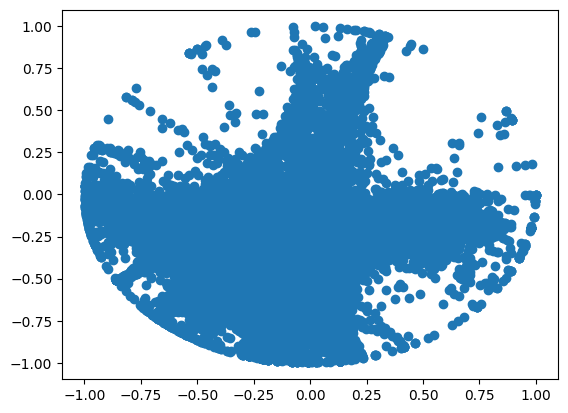

In [ ]:
# It bothers me that the get_mixture_embeddings() and mixture_embedding()
# functions look so different. What if I tweak the learning rates and such?

try_me = get_mixture_embeddings(
    # otu_table_df=adata_df.iloc[:1000],
    otu_table_df=adata_df,
    otu_embeddings_df=otu_embeddings.loc[adata_df.columns],
    space="hyperbolic",
    embedding_size=2,
    # fmean_model="poincare",
    fmean_model="hyperboloid",
    # mode="geomstats",
    mode="manual",
    max_iter=32,
    init_point=None,
    lr=1e-1,
    # lr=1,
    return_percent_converged=False,
    n_jobs=-1,
    convert_back=True,
    # convert_back=False,
)
# try_me_poi = np.array(
#     [convert_geometry_after("hyperboloid", "poincare", x) for x in try_me.values]
# )


plt.scatter(try_me[0], try_me[1])


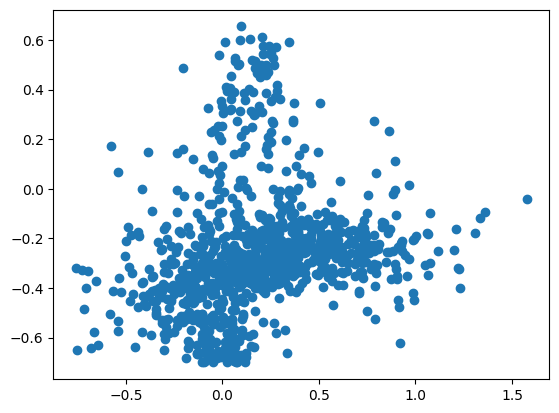

In [ ]:
plt.scatter(
    try_me[0],
    try_me[1],
)


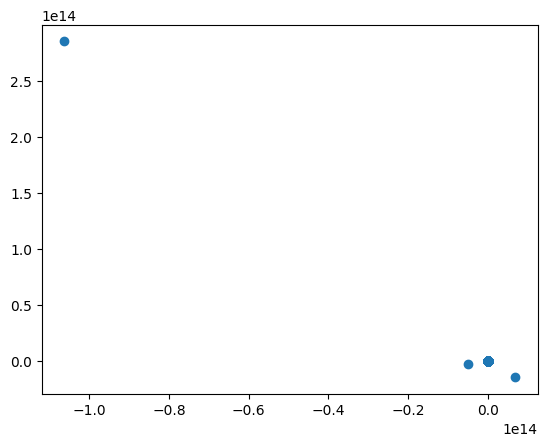

In [ ]:
plt.scatter(try_me[0], try_me[1])
# try_me


In [ ]:
import pickle

with open("data/pac_embeddings.pkl", "wb") as f:
    pickle.dump(pac_me, f)


In [ ]:
save_adata()


In [ ]:
# Add component embeddings

from src.embeddings.mixture_embeddings import convert_geometry_before

for ndim in [2, 4, 8, 16, 32, 64, 128]:
    for geom in ["euclidean", "hyperbolic"]:
        component_embeddings = pd.read_csv(
            f"/data/phil/otu_embeddings/embeddings_{geom}_{ndim}.csv",
            dtype={0: str},
        )
        component_embeddings = component_embeddings.set_index(
            component_embeddings.columns[0]
        )
        component_embeddings = component_embeddings.loc[adata_df.columns]
        if geom == "hyperbolic":
            adata.varm[
                f"component_embeddings_poincare_{ndim}"
            ] = component_embeddings
            if geom == "hyperbolic":
                ce_hyperboloid, _ = convert_geometry_before(
                    "hyperboloid",
                    "poincare",
                    component_embeddings.values,
                    init_point=None,
                )
                adata.varm[
                    f"component_embeddings_hyperboloid_{ndim}"
                ] = ce_hyperboloid
        else:
            adata.varm[
                f"component_embeddings_{geom}_{ndim}"
            ] = component_embeddings

save_adata()


Convert data from poincare to hyperboloid... (before)
Convert data from poincare to hyperboloid... (before)
Convert data from poincare to hyperboloid... (before)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
save_adata()
